In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import joblib
from openpyxl import load_workbook
from imblearn.over_sampling import SMOTE
from collections import Counter

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Bibliotecas dos Modelos Utilizados
from sklearn.tree import DecisionTreeClassifier      # Árvore de Decisões de Classificação.
from sklearn.ensemble import RandomForestClassifier  # Floresta Aleatória.
from xgboost import XGBClassifier                    # Extreme Gradient Boosting.

In [3]:
# Análise de Dados
from sklearn.decomposition import PCA

# Treinamento
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# Avalição
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, confusion_matrix, roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import label_binarize

# Tuning
from sklearn.model_selection import GridSearchCV

# Análise de Dados

In [4]:
# Carregar o DataFrame a partir de um arquivo Excel
caminho_arquivo_excel = 'C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\anonymizedData.xlsx'
nome_da_pagina = 'P_Suspensao'  # Nome da página desejada

# Lê o arquivo Excel com todas as páginas/sheets
xl = pd.ExcelFile(caminho_arquivo_excel)

df = xl.parse(nome_da_pagina)

# Vê dados 
df.head()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,DP_Altura do CG com relacao ao chao,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,...,CD_Distancia de frenagem de 35 a 0 em asfalto,CD_Distancia de frenagem de 35 a 0 em terra batida,CD_Ganho de rolagem por aceleracao lateral,CD_Ganho de arfagem em aceleracao longitudinal,CD_Ganho de arfagem em desaceleracao longitudinal,CD_Velocidade maxima de 0 a 100 metros em asfalto,CD_Velocidade maxima de 0 a 100 metros em terra batida,CD_Tempo para atingir velocidade maxima em asfalto,CD_Tempo para atingir velocidade maxima em terra batida,P_Suspensao
0,1403.343755,1464.830349,1384.813430,1650.169516,1931.095254,506.334809,84.391263,127.667651,0.400889,0.500616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1355.175580,1458.268851,1339.569317,1612.905747,1807.646429,NaN,85.875452,123.520084,0.446510,NaN,...,NaN,NaN,NaN,NaN,NaN,49.072302,NaN,5.699527,NaN,1
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1375.611808,1466.491046,1295.798366,1613.673946,1953.436224,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [5]:
# Linha a ser adicionada
linha = "1380,0000/ 1300/ 1190,0000/ 1551,7200/ 1880/ 469,6/ 114,32/ 86,58/ 0,432/ 0,519/ 629,4/ 788,8/ 189,6000/ 170/ 62/ 22,0000/ 0/ 0/ 245/ 62/ 22/ 0/ 0/ 2/ 69,4/6,8000/ 15/ 39/ 370,3/ 81/ 180/ 52/ 160,0000/ 7,0800/ 20,7/ 38/ 9,5/ 2080/ 30/ 6,4699/ 8,7287/ 3,6/ 0/ 0/ 43/ 41/ 4,2/ 4,4/ 5/"

# Separar os valores da linha
valores = linha.split("/")

# Converter os valores para float
valores_float = [float(valor.replace(",", ".")) for valor in valores[:-1]]

# Adicionar a nova linha ao final do DataFrame existente
df.loc[len(df)] = valores_float

# Verificar o DataFrame atualizado
print(df)

      DP_Entre-Eixo  DP_Bitola Dianteira  DP_Bitola Traseira    DP_Altura  \
0       1403.343755          1464.830349         1384.813430  1650.169516   
1       1355.175580          1458.268851         1339.569317  1612.905747   
2               NaN                  NaN                 NaN          NaN   
3               NaN                  NaN                 NaN          NaN   
4       1375.611808          1466.491046         1295.798366  1613.673946   
...             ...                  ...                 ...          ...   
996     1430.487914          1257.233399         1206.112317  1701.632149   
997     1351.128586          1347.759384         1187.922132  1527.291742   
998     1430.000000          1300.000000         1200.000000  1600.000000   
999             NaN                  NaN                 NaN          NaN   
1000    1380.000000          1300.000000         1190.000000  1551.720000   

      DP_Comprimento  DP_Altura do CG com relacao ao chao  MV_Eixo dianteir

In [6]:
# Remove as colunas que não trazem dados relevantes as provas
colunas_a_remover = [
    'DP_Altura do CG com relacao ao chao',
    'SD_Curso Positivo de projeto',
    'SD_Curso Negativo de projeto',
    'SD_Dimensoes dos pneus',
    'SD_Cambagem estatica',
    'SD_Convergência estatica',
    'ST_Curso Positivo de projeto',
    'ST_Curso Negativo de projeto',
    'ST_Dimensoes dos pneus',
    'ST_Cambagem estatica',
    'ST_Convergência estatica',
    'D_Curso total da cremalheira',
    'D_Inclinacao do pino mestre',
    'D_Angulo de caster',
    'FD_Pressao no sistema a 07g ',
    'FD_Forca no pedal a 07g ',
    'FD_Curso total do pedal ',
    'FD_Diametro do disco ',
    'FT_Pressao no sistema a 07g ',
    'FT_Diametro do disco ',
    'MT_Potência maxima do motor',
    'MT_Torque maximo do motor',
    'CD_Raio mínimo de curva do protótipo',
    'CD_Velocidade crítica para uma curva de raio de 10 m',
    'CD_Distancia de frenagem de 35 a 0 em asfalto',
    'CD_Distancia de frenagem de 35 a 0 em terra batida',
    'CD_Ganho de rolagem por aceleracao lateral',
    'CD_Ganho de arfagem em aceleracao longitudinal',
    'CD_Ganho de arfagem em desaceleracao longitudinal',
    'CD_Velocidade maxima de 0 a 100 metros em asfalto ',
    'CD_Velocidade maxima de 0 a 100 metros em terra batida ',
    'CD_Tempo para atingir velocidade maxima em asfalto',
    'CD_Tempo para atingir velocidade maxima em terra batida',
]

# Remove as colunas especificadas
df = df.drop(colunas_a_remover, axis=1)

In [7]:
# Informação básica
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1001 entries, 0 to 1000
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   DP_Entre-Eixo         780 non-null    float64
 1   DP_Bitola Dianteira   780 non-null    float64
 2   DP_Bitola Traseira    780 non-null    float64
 3   DP_Altura             780 non-null    float64
 4   DP_Comprimento        780 non-null    float64
 5   MV_Eixo dianteiro     762 non-null    float64
 6   MV_Eixo Traseiro      762 non-null    float64
 7   DMV_Dianteira         762 non-null    float64
 8   DMV_Lado Direito      292 non-null    float64
 9   PCG_X                 762 non-null    float64
 10  PCG_Y                 983 non-null    float64
 11  PCG_Z                 762 non-null    float64
 12  D_Relacao             614 non-null    float64
 13  MT_Relacao total_max  768 non-null    float64
 14  MT_Relacao total_min  756 non-null    float64
 15  P_Suspensao          

In [8]:
#Descrição de dados
df.describe()

,DP_Entre-Eixo,DP_Bitola Dianteira,DP_Bitola Traseira,DP_Altura,DP_Comprimento,MV_Eixo dianteiro,MV_Eixo Traseiro,DMV_Dianteira,DMV_Lado Direito,PCG_X,PCG_Y,PCG_Z,D_Relacao,MT_Relacao total_max,MT_Relacao total_min,P_Suspensao
count,780.000000,780.000000,780.000000,780.000000,780.000000,762.000000,762.000000,762.000000,292.000000,762.000000,983.000000,762.000000,614.000000,768.000000,756.000000,1001.000000
mean,1418.899475,1328.026824,1257.718186,1529.470220,2004.864763,75.471561,105.706652,0.416797,0.499576,269.658949,144.474170,54.589091,2.574778,28.107414,5.668879,3.001998
std,52.586378,66.006372,78.732386,183.412265,63.733277,11.832442,13.979075,0.028106,0.036439,265.414486,226.454481,4571.780275,0.644549,6.507164,1.579089,1.415626
min,1300.000000,881.424415,906.653036,283.775875,1767.135978,49.868677,78.230737,0.317883,0.169324,-255.720918,-104.790615,-123737.654930,1.042772,3.292976,0.460516,1.000000
25%,1381.706947,1288.587856,1204.298193,1497.272386,1975.499166,68.027142,97.031312,0.396263,0.483549,71.218728,-0.000466,183.307792,2.158249,26.126622,4.800203,2.000000
50%,1415.334870,1322.019155,1240.991421,1531.718943,2006.486252,73.062379,103.309960,0.416882,0.493438,134.386851,6.744967,254.542190,2.446174,28.622207,5.790248,3.000000
75%,1457.386417,1367.166061,1299.670878,1582.807755,2042.028661,79.235012,111.250619,0.436893,0.501210,492.866796,229.464648,401.361897,2.892060,31.737078,6.683468,4.000000
max,1602.304548,1555.934563,1489.252580,2393.897090,2187.559482,131.882184,156.788911,0.475935,0.689371,845.120992,1024.268514,721.079742,5.732285,44.945929,9.807661,5.000000


In [9]:
# Inicialize um dicionário para armazenar o número de zeros em cada coluna
contagem_zeros = {}

# Loop através de todas as colunas
for coluna in df.columns:
    # Use a função sum() para contar a quantidade de zeros (0) na coluna
    zeros_na_coluna = (df[coluna] == 0).sum()
    
    # Armazene o resultado no dicionário
    contagem_zeros[coluna] = zeros_na_coluna

# Exiba a contagem de zeros em cada coluna
for coluna, zeros in contagem_zeros.items():
    print(f"'{coluna}' tem {zeros}.") 

'DP_Entre-Eixo' tem 0.
'DP_Bitola Dianteira' tem 0.
'DP_Bitola Traseira' tem 0.
'DP_Altura' tem 0.
'DP_Comprimento' tem 0.
'MV_Eixo dianteiro' tem 0.
'MV_Eixo Traseiro' tem 0.
'DMV_Dianteira' tem 0.
'DMV_Lado Direito' tem 0.
'PCG_X' tem 0.
'PCG_Y' tem 35.
'PCG_Z' tem 0.
'D_Relacao' tem 0.
'MT_Relacao total_max' tem 0.
'MT_Relacao total_min' tem 0.
'P_Suspensao' tem 0.


## Limpeza

In [10]:
# Limpar o Dataset das colunas com muitos valores nulos

limite_nulos = 700 # Define o limite de valores nulos permitidos

# Remove as colunas com mais de limite_nulos valores nulos
df = df.dropna(thresh=len(df) - limite_nulos, axis=1)

# Checar 
df.isnull().sum()

DP_Entre-Eixo           221
DP_Bitola Dianteira     221
DP_Bitola Traseira      221
DP_Altura               221
DP_Comprimento          221
MV_Eixo dianteiro       239
MV_Eixo Traseiro        239
DMV_Dianteira           239
PCG_X                   239
PCG_Y                    18
PCG_Z                   239
D_Relacao               387
MT_Relacao total_max    233
MT_Relacao total_min    245
P_Suspensao               0
dtype: int64

In [11]:
# Verifique quais linhas têm mais de 8 valores iguais nulos
linhas_quase_nulas = df[df.isnull().sum(axis=1) > 8]

# Exiba as linhas que atendem à condição
print(linhas_quase_nulas.index)

# Exclua as linhas com base nos índices coletados
df = df.drop(linhas_quase_nulas.index)

# Exiba o DataFrame resultante
print(df)

Int64Index([  2,   3,   5,   8,  12,  13,  14,  15,  17,  21,
            ...
            979, 980, 981, 983, 986, 987, 988, 991, 992, 999],
           dtype='int64', length=222)
      DP_Entre-Eixo  DP_Bitola Dianteira  DP_Bitola Traseira    DP_Altura  \
0       1403.343755          1464.830349         1384.813430  1650.169516   
1       1355.175580          1458.268851         1339.569317  1612.905747   
4       1375.611808          1466.491046         1295.798366  1613.673946   
6       1377.823365          1358.577746         1234.377233  1525.984408   
7       1453.776123          1500.000000         1412.056653  1542.274357   
...             ...                  ...                 ...          ...   
995     1437.572127          1276.808399         1200.000000  1627.460455   
996     1430.487914          1257.233399         1206.112317  1701.632149   
997     1351.128586          1347.759384         1187.922132  1527.291742   
998     1430.000000          1300.000000         12

In [12]:
# Mapeie os valores existentes para os novos valores
mapeamento = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}

# Use a função 'replace' para fazer a substituição
df['P_Suspensao'] = df['P_Suspensao'].replace(mapeamento)

print(df['P_Suspensao'])

0       0.0
1       0.0
4       0.0
6       0.0
7       0.0
       ... 
995     4.0
996     4.0
997     4.0
998     4.0
1000    4.0
Name: P_Suspensao, Length: 779, dtype: float64


In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado.xlsx"

# Salvar o DataFrame na planilha 'P_Aceleration'
df.to_excel(caminho_arquivo, sheet_name='P_Aceleration', index=False)

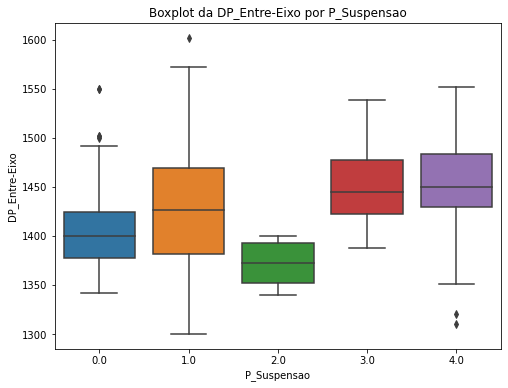

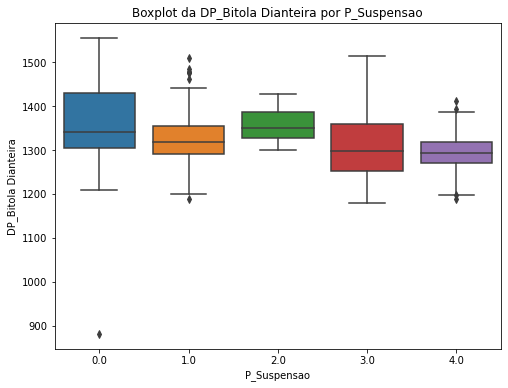

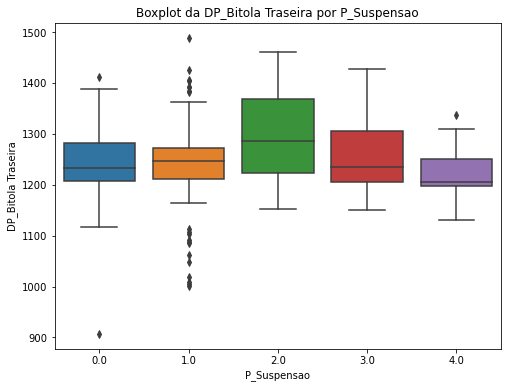

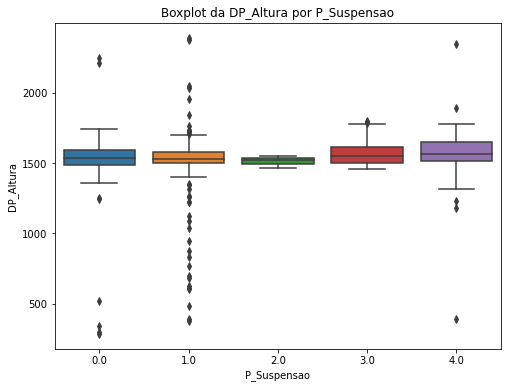

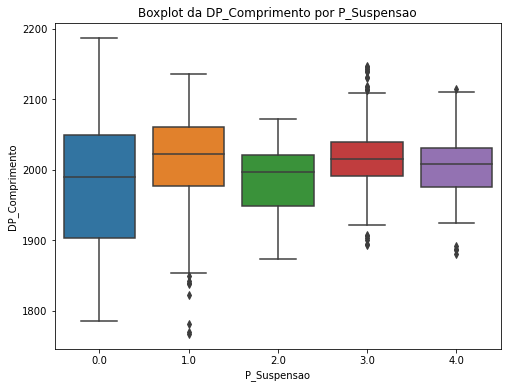

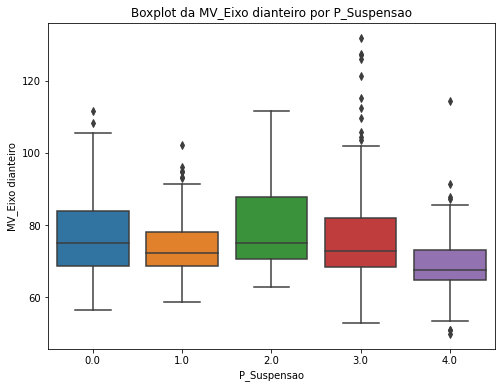

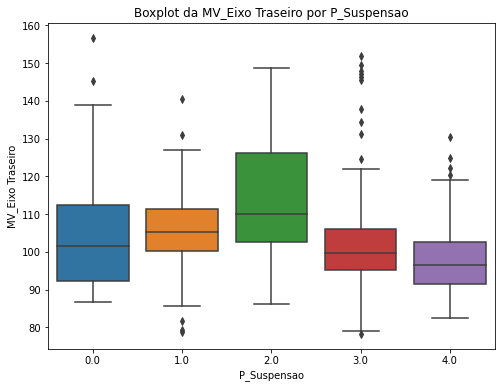

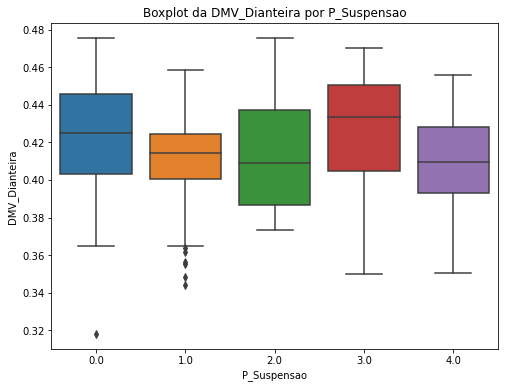

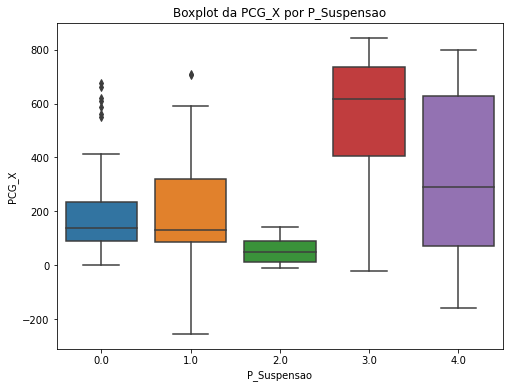

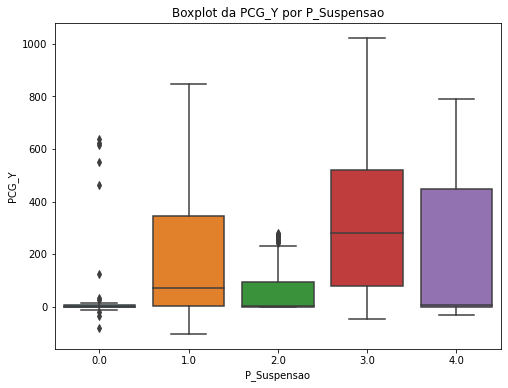

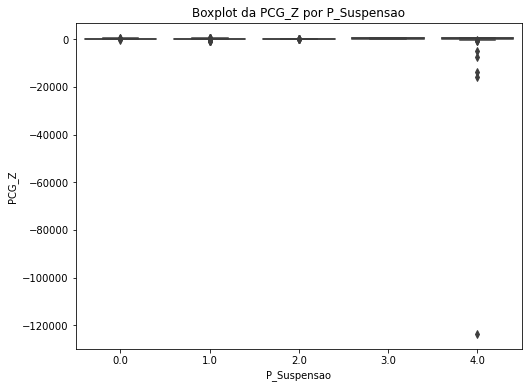

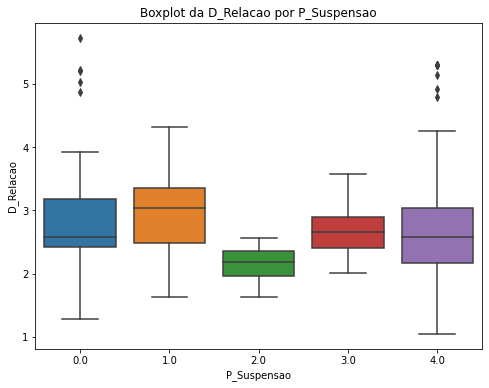

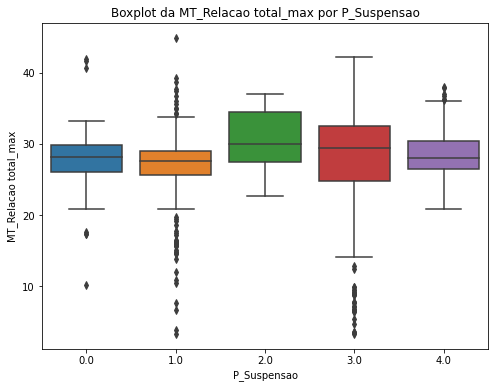

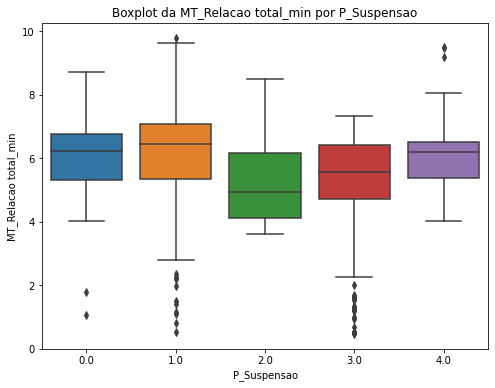

In [13]:
# Boxplots por Classes
for coluna in df.columns:
    if coluna != 'P_Suspensao':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Suspensao', y=coluna, data=df)
        plt.title(f'Boxplot da {coluna} por P_Suspensao')
        plt.ylabel(coluna)
        plt.xlabel('P_Suspensao')
        plt.show()

In [14]:
# Tratar Outliers e valores nulos
colunas_a_tratar = df.columns.difference(['P_Suspensao']) # Lista das colunas a serem tratadas 


# Lista das classes únicas na coluna 'Classe'
classes_unicas = df['P_Suspensao'].unique()

# Função para tratar uma coluna específica em uma classe
def tratar_coluna_para_classe(data, classe, coluna):
    dados_classe = data[data['P_Suspensao'] == classe]
    
    # Calcula a mediana dos valores não nulos da coluna para esta classe
    mediana = dados_classe[coluna].median()
    
    # Calcula o desvio padrão dos valores não nulos da coluna para esta classe
    desvio_padrao = dados_classe[coluna].std()
    
    # Define o limite superior e inferior com base no desvio padrão
    limite_superior = mediana + (2 * desvio_padrao)
    limite_inferior = mediana - (2 * desvio_padrao)
    
    # Substitui os valores que são nulos ou estão fora do limite pelo valor da mediana
    dados_classe[coluna] = dados_classe[coluna].apply(lambda x: mediana if pd.isna(x) or x > limite_superior or x < limite_inferior else x)
    
    return dados_classe

# Loop para tratar todas as colunas para cada classe
dados_tratados = []
for classe in classes_unicas:
    dados_classe = df[df['P_Suspensao'] == classe].copy()  # Crie uma cópia dos dados da classe
    for coluna in colunas_a_tratar:
        dados_classe = tratar_coluna_para_classe(dados_classe, classe, coluna)
    dados_tratados.append(dados_classe)

# Concatena os dados tratados de volta em um único DataFrame
df_tratado = pd.concat(dados_tratados)

#print(df)

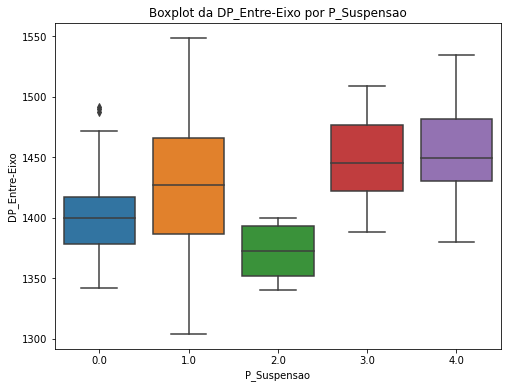

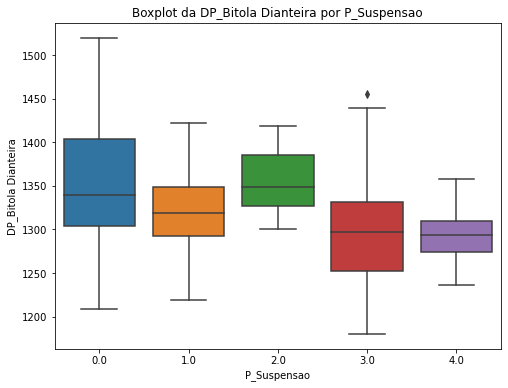

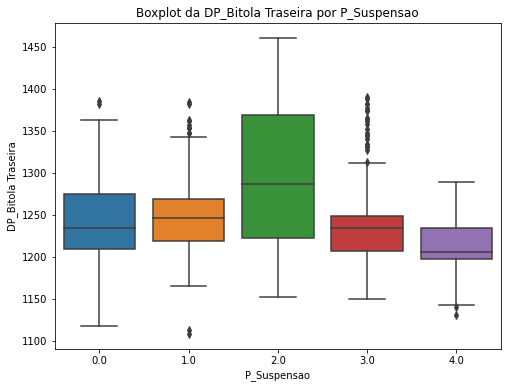

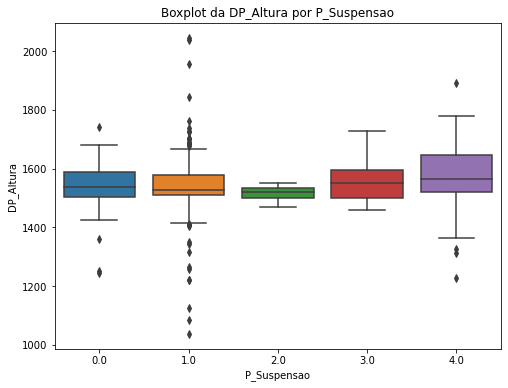

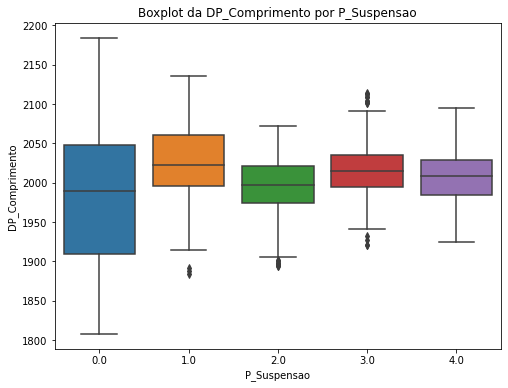

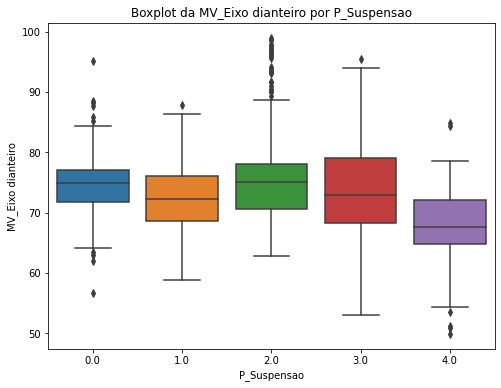

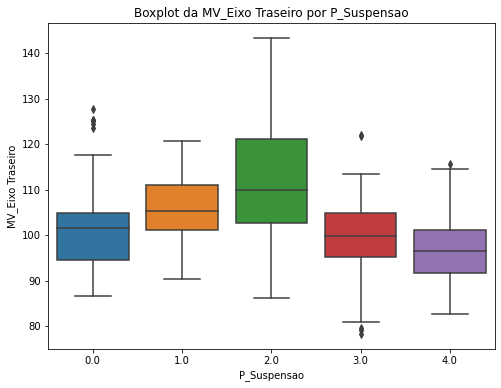

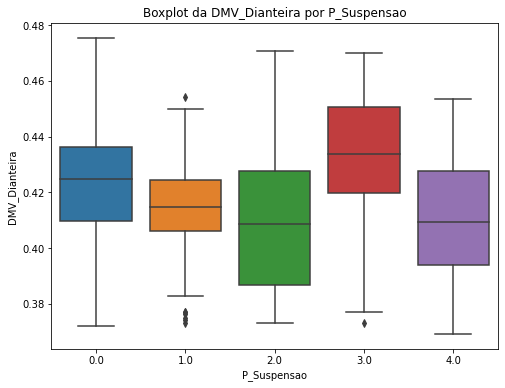

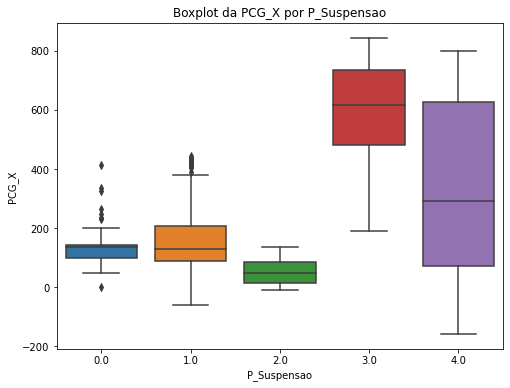

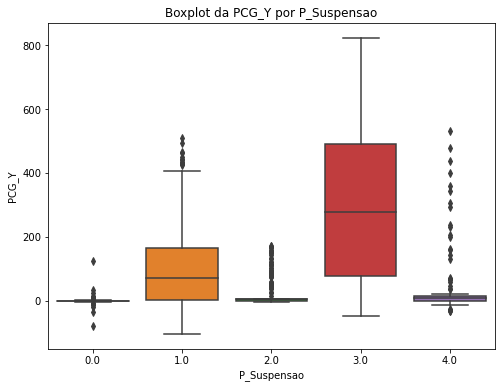

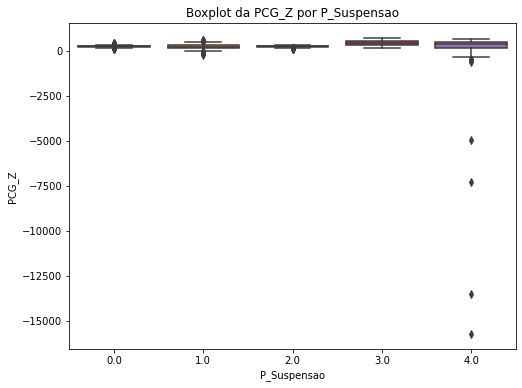

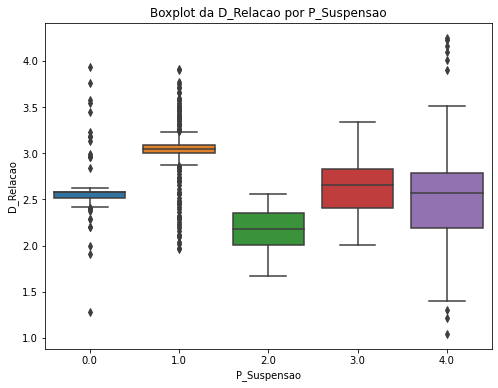

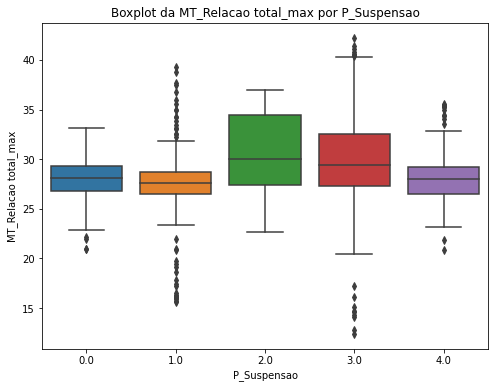

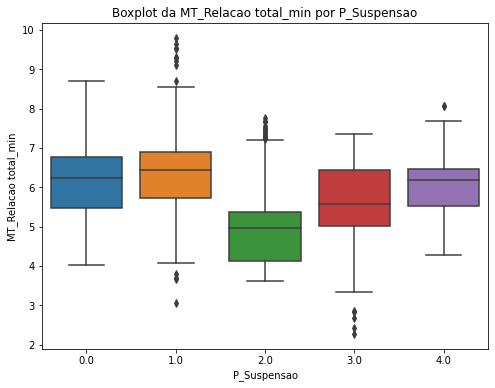

In [15]:
# Boxplots por Classes
for coluna in df_tratado.columns:
    if coluna != 'P_Suspensao':  # Excluindo a coluna de classe das análises
        plt.figure(figsize=(8, 6))
        sns.boxplot(x='P_Suspensao', y=coluna, data=df_tratado)
        plt.title(f'Boxplot da {coluna} por P_Suspensao')
        plt.ylabel(coluna)
        plt.xlabel('P_Suspensao')
        plt.show()

In [16]:
df = df_tratado

In [ ]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Arquivo_Processado_semO.xlsx"

# Carregar o arquivo Excel existente
book = load_workbook(caminho_arquivo)

# Adicionar o DataFrame como um novo sheet
with pd.ExcelWriter(caminho_arquivo, engine='openpyxl', mode='a') as writer:
    writer.book = book
    novo_dataframe.to_excel(writer, sheet_name='P_Velocidade', index=False)

## Análise de Variáveis

In [17]:
data_corr = df.drop(['P_Suspensao'], axis=1)
# Análise de correlação dos parâmetros
correlation = df.corr()

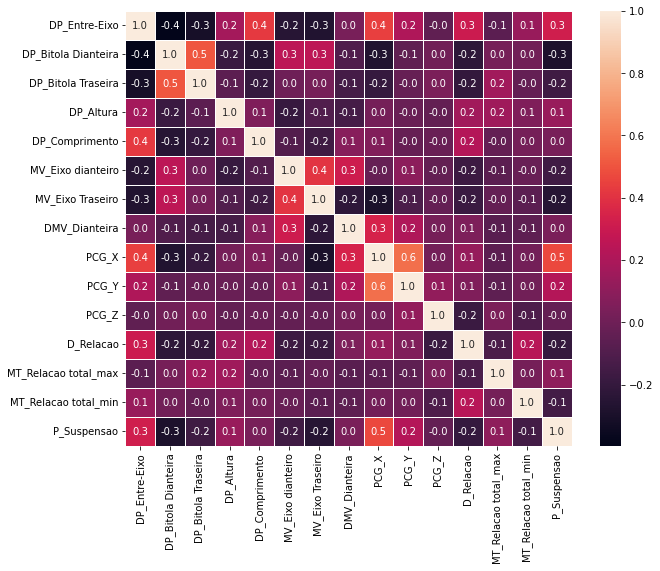

In [18]:
# Plot da matriz de correlação
plt.figure(figsize=(10, 8))

plot = sns.heatmap(correlation, annot = True, fmt=".1f", linewidths=0.5)
plt.show()

In [19]:
# Aplicar PCA para reduzir variáveis de alta correlação - DP_Bitola
variaveis_reduzidas = df[['DP_Bitola Dianteira', 'DP_Bitola Traseira']]

pca = PCA(n_components=1)
variavel_reduzida = pca.fit_transform(variaveis_reduzidas)

# Remove as colunas reduzidas
colunas_a_remover = [
    'DP_Bitola Dianteira',
    'DP_Bitola Traseira',
]

df = df.drop(colunas_a_remover, axis=1)

# Escolha a posição (índice) onde deseja inserir a nova coluna
posicao_desejada = 1

# Insira a nova coluna no DataFrame na posição desejada
df.insert(posicao_desejada, 'DP_Bitola', variavel_reduzida)

print(df)

      DP_Entre-Eixo   DP_Bitola    DP_Altura  DP_Comprimento  \
0       1403.343755  190.211270  1650.169516     1931.095254   
1       1355.175580  149.292647  1612.905747     1807.646429   
4       1375.611808  118.008937  1613.673946     1953.436224   
6       1377.823365    6.042490  1525.984408     2048.951826   
7       1453.776123   85.933886  1542.274357     2139.937218   
...             ...         ...          ...             ...   
995     1437.572127  -68.802612  1627.460455     2007.075820   
996     1430.487914  -74.934386  1701.632149     2030.654875   
997     1449.441174  -38.296998  1527.291742     1984.978929   
998     1430.000000  -55.587121  1600.000000     1965.000000   
1000    1380.000000  -63.804681  1551.720000     2008.288354   

      MV_Eixo dianteiro  MV_Eixo Traseiro  DMV_Dianteira       PCG_X  \
0             84.391263        127.667651       0.400889  236.156465   
1             85.875452        123.520084       0.446510  414.076579   
4             7

In [20]:
# Obtenha as proporções da variância explicada por cada componente
variance_explained = pca.explained_variance_ratio_

# Calcule a variância explicada acumulativa
cumulative_variance_explained = np.cumsum(variance_explained)

# Imprima as proporções de variância explicada
print("Variância Explicada por Componente:")
print(variance_explained)

# Imprima a variância explicada acumulativa
print("\nVariância Explicada Acumulativa:")
print(cumulative_variance_explained)

Variância Explicada por Componente:
[0.76569372]

Variância Explicada Acumulativa:
[0.76569372]


In [22]:
# Remova a última linha do DataFrame e armazene-a em uma variável separada
dados_MB24 = df.iloc[-1]
df = df.iloc[:-1]

dados_MB24 = dados_MB24.drop('P_Suspensao')

# Converta a série em um DataFrame com uma única linha
dados_MB24 = dados_MB24.to_frame().T

print(dados_MB24)

     DP_Entre-Eixo  DP_Bitola  DP_Altura  DP_Comprimento  MV_Eixo dianteiro  \
998         1430.0 -55.587121     1600.0          1965.0          54.311767   

     MV_Eixo Traseiro  DMV_Dianteira      PCG_X     PCG_Y      PCG_Z  \
998         82.593444       0.385958  72.474134  0.011081  144.35865   

     D_Relacao  MT_Relacao total_max  MT_Relacao total_min  
998   2.571446             28.489514              4.901426  


## Balanceamento de Classes

In [23]:
# Separar X e Y
X = df.iloc[:, :-1]
Y = df.iloc[:, -1]

In [24]:
# Verificar o balanceamento original
print('Contagem de classes antes do SMOTE:', Counter(Y))

Contagem de classes antes do SMOTE: Counter({1.0: 200, 2.0: 200, 3.0: 200, 4.0: 106, 0.0: 71})


In [25]:
# Aplicar SMOTE ao conjunto inteiro
smote = SMOTE(sampling_strategy='auto', random_state=42)
X, Y = smote.fit_resample(X, Y)

In [26]:
# Verificar a contagem de classes após o SMOTE
print('Contagem de classes após o SMOTE:', Counter(Y))

Contagem de classes após o SMOTE: Counter({0.0: 200, 1.0: 200, 2.0: 200, 3.0: 200, 4.0: 200})


In [27]:
# Junte X e Y em um único DataFrame
df = pd.concat([X, Y], axis=1)
print(df)

     DP_Entre-Eixo   DP_Bitola    DP_Altura  DP_Comprimento  \
0      1403.343755  190.211270  1650.169516     1931.095254   
1      1355.175580  149.292647  1612.905747     1807.646429   
2      1375.611808  118.008937  1613.673946     1953.436224   
3      1377.823365    6.042490  1525.984408     2048.951826   
4      1453.776123   85.933886  1542.274357     2139.937218   
..             ...         ...          ...             ...   
995    1463.755036  -45.703785  1484.653962     2029.098577   
996    1429.278314  -52.810622  1471.446879     2041.671047   
997    1429.454303  -64.448879  1600.000000     1968.822842   
998    1440.305300  -65.649240  1587.844874     2002.636186   
999    1457.767730  -29.075341  1502.370531     1983.964024   

     MV_Eixo dianteiro  MV_Eixo Traseiro  DMV_Dianteira       PCG_X  \
0            84.391263        127.667651       0.400889  236.156465   
1            85.875452        123.520084       0.446510  414.076579   
2            74.950803        

In [28]:
# Dividir o conjunto de dados em treinamento e teste
dados_treino, dados_teste = train_test_split(df, test_size=0.3)

X_treino = dados_treino.iloc[:, :-1]
Y_treino = dados_treino.iloc[:, -1]

X_teste = dados_teste.iloc[:, :-1]
Y_teste = dados_teste.iloc[:, -1]

print(dados_teste)

     DP_Entre-Eixo   DP_Bitola    DP_Altura  DP_Comprimento  \
37     1449.750033  -32.781586  1742.601129     1989.216182   
810    1458.750380  -76.548786  1702.403353     2039.328992   
304    1361.931639  103.630883  1507.313144     1909.535214   
599    1405.912138  145.384996  1501.497522     1970.743692   
318    1342.550862   51.529028  1486.740385     1915.528894   
..             ...         ...          ...             ...   
790    1420.509621  -65.057094  1246.405639     1990.746265   
568    1407.382292   41.794485  1483.795123     2003.145305   
375    1363.330431  -63.996080  1537.090799     2069.132896   
19     1355.422754  -35.269614  1679.500261     2080.000000   
263    1382.636965   14.172356  1527.150200     1970.874500   

     MV_Eixo dianteiro  MV_Eixo Traseiro  DMV_Dianteira       PCG_X  \
37           76.299980        117.496318       0.381994  137.106398   
810          72.401780        111.859913       0.392895  111.907326   
304          70.589954        

In [31]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Dados Treino\\dadostreino_sus.xlsx"

# Adicionar o DataFrame na planilha 'P_Frenagem'
dados_treino.to_excel(caminho_arquivo, sheet_name='P_Suspensao', index=False)

In [32]:
# Especifique o caminho para o arquivo Excel
caminho_arquivo = "C:\\Users\\Andre\\Desktop\\Julia\\Mangue_Baja\\DESAFIO TÉCNICO\\Dados Teste\\dadosteste_sus.xlsx"

# Adicionar o DataFrame na planilha 'P_Frenagem'
dados_teste.to_excel(caminho_arquivo, sheet_name='P_Suspensao', index=False)

# Pré-seleção do Modelo

## Árvore de Decisão de Classificação

In [33]:
# Modelo de Árvore de Decisão de Classificação.
model_DTC = DecisionTreeClassifier()
model_DTC.fit(X_treino, Y_treino)

DecisionTreeClassifier()

## Classificação de Floresta Aleatória

In [34]:
# Modelo de Regressão de Floresta Aleatória.
model_RFC = RandomForestClassifier()
model_RFC.fit(X_treino, Y_treino)

RandomForestClassifier()

## Extreme Gradient Boosting

In [35]:
# Modelo de Extreme Gradient Boosting.
model_XGB = XGBClassifier()
model_XGB.fit(X_treino, Y_treino)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Refinamento do Modelo

## Árvore de Decisão de Classificação

In [36]:
# Exemplo de Tuning
param_grid = {
    'criterion': ['gini', 'entropy'],        # Avaliar a qualidade da divisão
    'max_depth': [None, 5, 10, 15],          # Profundidade máxima das árvores 
    'min_samples_split': [2, 5, 10],         # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],           # Número mínimo de amostras em uma folha
    'max_features': [None, 'sqrt', 'log2']   # Número máximo de recursos a serem considerados em cada divisão
}
grid_search = GridSearchCV(estimator=model_DTC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [37]:
# Ajustar um modelo de Árvore de Decisão
model_DTC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_DTC.set_params(**best_params)

DecisionTreeClassifier(criterion='entropy')

## Classificação de Floresta Aleatória

In [38]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [10, 20, 30],           # Número de árvores na floresta
    'max_depth': [None, 10, 20, 30],        # Profundidade máxima das árvores
    'min_samples_split': [2, 5, 10],        # Número mínimo de amostras necessárias para dividir um nó
    'min_samples_leaf': [1, 2, 4],          # Número mínimo de amostras em uma folha
    'max_features': ['auto', 'sqrt']        # Número máximo de recursos a serem considerados em cada divisão
}

grid_search = GridSearchCV(estimator=model_RFC, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params_RFC = grid_search.best_params_
best_estimator = grid_search.best_estimator_


540 fits failed out of a total of 1080.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\Andre\anaconda3\lib\site-packages\sklearn\utils\_param_validation.py", line 96, in validate_parameter_constraints
    raise InvalidPara

In [ ]:
# Guardar os parâmetros encontrados fora do código
#melhores_parametros = grid_search.best_params_

# Salvar os melhores parâmetros em um arquivo
#joblib.dump(melhores_parametros, 'melhores_parametros_acel.pkl')

# Carregar os melhores parâmetros a partir do arquivo
#melhores_parametros = joblib.load('melhores_parametros_acel.pkl')

In [ ]:
# Ajustar um modelo de Floresta Aleatória
model_RFC.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_RFC.set_params(**best_params_RFC)

## Extreme Gradient Boosting

In [39]:
# Exemplo de Tuning
param_grid = {
    'n_estimators': [100, 200, 300],       # Número de árvores na floresta
    'max_depth': [3, 4, 5],                # Profundidade máxima das árvores
    'learning_rate': [0.1, 0.01],          # Taxa de aprendizado
    'subsample': [0.8, 0.9, 1.0],          # Fração de amostras usadas para treinamento de cada árvore
    'min_child_weight': [1, 5, 10],        # Peso mínimo das amostras necessárias em uma folha
    'gamma': [0, 0.1, 0.2],                # Regularização gamma (parâmetro de penalização)
}

grid_search = GridSearchCV(estimator=model_XGB, param_grid=param_grid, cv=5)

grid_search.fit(X_treino, Y_treino)

best_params_XGB = grid_search.best_params_
best_estimator = grid_search.best_estimator_

In [40]:
# Ajustar um modelo de XGBoost
model_XGB.fit(X_treino, Y_treino)

# Configure o modelo com os melhores parâmetros
model_XGB.set_params(**best_params_XGB)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

# Validação Cruzada

In [41]:
# Número de classes
n_classes = 5

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

## Árvore de Decisão de Classificação

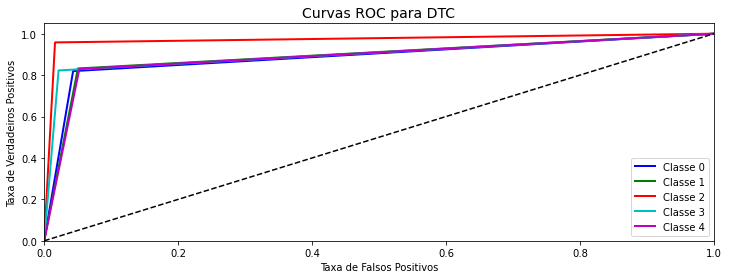

In [42]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_DTC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para DTC', fontsize=14)
plt.show()

In [43]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_DTC, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 85.43%
Intervalo de acurácia: [79.60% ~ 91.26%]


In [44]:
# Relatório do modelo
Y_pred = model_DTC.predict(X_teste)

print('Relatório de classificação DTC:\n', classification_report(Y_teste, Y_pred, digits=4))

Relatório de classificação DTC:
               precision    recall  f1-score   support

         0.0     0.8214    0.8214    0.8214        56
         1.0     0.8235    0.7368    0.7778        57
         2.0     0.9643    0.9474    0.9558        57
         3.0     0.7846    0.8644    0.8226        59
         4.0     0.8194    0.8310    0.8252        71

    accuracy                         0.8400       300
   macro avg     0.8427    0.8402    0.8405       300
weighted avg     0.8413    0.8400    0.8398       300



## Classificação de Floresta Aleatória

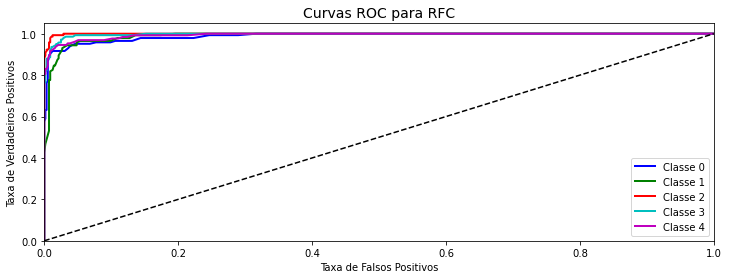

In [46]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para RFC', fontsize=14)
plt.show()

In [47]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_RFC, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 93.00%
Intervalo de acurácia: [88.63% ~ 97.37%]


In [48]:
# Relatório do modelo
Y_pred = model_RFC.predict(X_teste)

print('Relatório de classificação DTC:\n', classification_report(Y_teste, Y_pred, digits=4))

Relatório de classificação DTC:
               precision    recall  f1-score   support

         0.0     0.9273    0.9107    0.9189        56
         1.0     0.9000    0.9474    0.9231        57
         2.0     1.0000    0.9825    0.9912        57
         3.0     0.8507    0.9661    0.9048        59
         4.0     1.0000    0.8732    0.9323        71

    accuracy                         0.9333       300
   macro avg     0.9356    0.9360    0.9340       300
weighted avg     0.9381    0.9333    0.9338       300



## Extreme Gradient Boosting

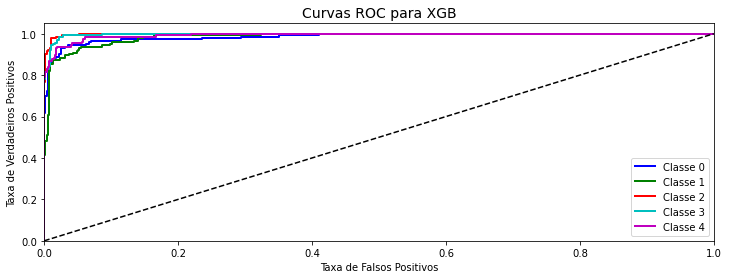

In [49]:
# Receiver operating characteristic — ROC

# Converta Y_treino para uma matriz binária de classes
Y_bin = label_binarize(Y_treino, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold, method='predict_proba')

# Calcula as curvas ROC para cada classe
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(Y_bin[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plote as curvas ROC para cada classe
fig, ax = plt.subplots(figsize=(12, 4))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color, lw=2, label='Classe {}'.format(i))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.legend(loc='lower right')
plt.title('Curvas ROC para XGB', fontsize=14)
plt.show()

In [50]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
def intervalo(results):
    mean = results.mean()
    dv = results.std()
    print('Acurácia média: {:.2f}%'.format(mean * 100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'.format((mean - 2 * dv) * 100, (mean + 2 * dv) * 100))

scores = cross_val_score(model_XGB, X_treino, Y_treino, cv=kfold, scoring='accuracy') # Checar Modelo
intervalo(scores)

Acurácia média: 92.57%
Intervalo de acurácia: [87.26% ~ 97.89%]


In [51]:
# Relatório do modelo
Y_pred = model_XGB.predict(X_teste)

print('Relatório de classificação DTC:\n', classification_report(Y_teste, Y_pred, digits=4))

Relatório de classificação DTC:
               precision    recall  f1-score   support

         0.0     0.8947    0.9107    0.9027        56
         1.0     0.9123    0.9123    0.9123        57
         2.0     0.9821    0.9649    0.9735        57
         3.0     0.8636    0.9661    0.9120        59
         4.0     0.9688    0.8732    0.9185        71

    accuracy                         0.9233       300
   macro avg     0.9243    0.9254    0.9238       300
weighted avg     0.9261    0.9233    0.9235       300



# Desempate

In [ ]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_RFC, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

In [ ]:
# Matriz de Confusão
Y_pred = cross_val_predict(model_XGB, X_treino, Y_treino, cv=kfold) # Checar Modelo

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(Y_treino, Y_pred), annot=True, ax=ax, fmt='d', cmap='Reds', cbar=False, square=True)
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("True label")
ax.set_xlabel("Predicted Label")
plt.tight_layout()

# Treinamento

In [56]:
# Treinamento do modelo 
model_RFC.fit(X_treino, Y_treino) # Checar modelo

RandomForestClassifier()

# Avaliação

In [57]:
# Fazer previsões no conjunto de teste
Y_pred = model_RFC.predict(X_teste)

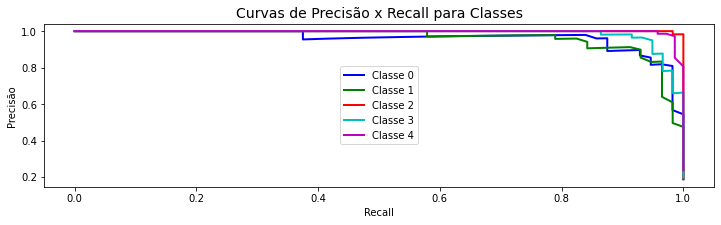

In [58]:
# Comparar scores de Previsão e Recall
# Converta Y_teste para uma matriz binária de classes
Y_bin = label_binarize(Y_teste, classes=list(range(5)))

# Obter as probabilidades em vez das previsões
y_scores = model_RFC.predict_proba(X_teste)

# Calcula as curvas de precisão e recall para cada classe
precisions = dict()
recalls = dict()
for i in range(5):
    precision, recall, _ = precision_recall_curve(Y_bin[:, i], y_scores[:, i])
    precisions[i] = precision
    recalls[i] = recall

# Plote as curvas de precisão e recall para cada classe
fig, ax = plt.subplots(figsize=(12, 3))
colors = ['b', 'g', 'r', 'c', 'm']
for i, color in zip(range(5), colors):
    plt.plot(recalls[i], precisions[i], color, lw=2, label='Classe {}'.format(i))

plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.legend(loc='center')
plt.title('Curvas de Precisão x Recall para Classes', fontsize=14)
plt.show()

In [59]:
# Calcule a média das pontuações para avaliação de Acurácia do modelo
Y_pred = model_RFC.predict(X_teste)

# Calcule a acurácia
accuracy = accuracy_score(Y_teste, Y_pred)

print(f'Acurácia no conjunto de teste: {accuracy:.2f}')

Acurácia no conjunto de teste: 0.93


## Análise de Variáveis 

In [60]:
# Analisar variáveis que mais afetam o modelo
importances = model_RFC.feature_importances_

# Classifique as importâncias das características
indices_ordenados = np.argsort(importances)[::-1]

print(importances)

[0.0991974  0.04159975 0.04753475 0.04553115 0.03747586 0.05156665
 0.05473008 0.17017487 0.08998842 0.08432824 0.14433159 0.06480907
 0.06873217]


 97%|=================== | 1455/1500 [00:17<00:00]       

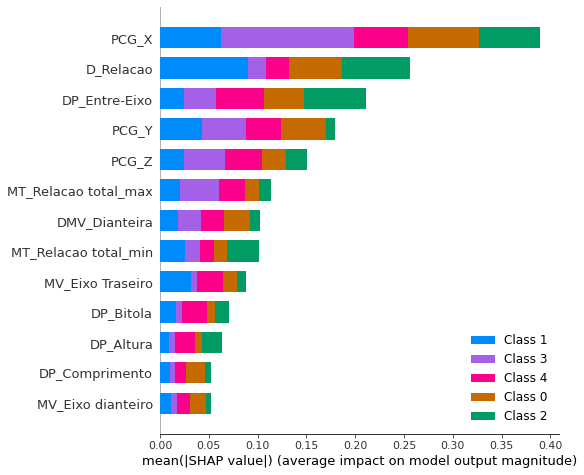

In [61]:
# Crie um objeto explainer
explainer = shap.Explainer(model_RFC, X_treino)

# Calcule os valores Shapley para um exemplo de dado específico
shap_values = explainer.shap_values(X_teste)

# Visualize os valores Shapley
shap.summary_plot(shap_values, X_teste)

# Predição

In [62]:
# Valor único para fazer a previsão
X_prev = dados_MB24

# Faça a previsão
previsao = model_RFC.predict(X_prev)

# Imprima a previsão
print(f'A previsão para X_prev é: {previsao[0]:.2f}')

A previsão para X_prev é: 4.00
